In [2]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

linkname = 'C:/Users/dell/Downloads/bank/bank-full.csv'
dataset1 = pd.read_csv(linkname, sep = ';')

In [3]:
# View the first 5 rows in the dataset
dataset1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Step 1: Delete the rows which column 'poutcome' contains 'other'
condition = dataset1.poutcome == 'other'
dataset2 = dataset1.drop(dataset1[condition].index, axis = 0, inplace = False)

In [5]:
# Step 2: Replace 'unknown' in job and education with 'other'
dataset2[['job','education']] = dataset2[['job','education']].replace(['unknown'],'other')

In [6]:
from scipy.stats import zscore

dataset2[['balance']].mean()
dataset2[['balance']].mean()

dataset2['balance_outliers'] = dataset2['balance']
dataset2['balance_outliers']= zscore(dataset2['balance_outliers'])

condition1 = (dataset2['balance_outliers']>3) | (dataset2['balance_outliers']<-3 )
dataset3 = dataset2.drop(dataset2[condition1].index, axis = 0, inplace = False)

In [7]:
dataset4 = dataset3.drop('balance_outliers', axis=1)

In [8]:
# Step 1: Change column name: 'y' to 'response'
dataset4.rename(index=str, columns={'y': 'response'}, inplace = True)

def convert(dataset4, new_column, old_column):
    dataset4[new_column] = dataset4[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return dataset4[new_column].value_counts()

convert(dataset4, "response_binary", "response")

0    37785
1     4870
Name: response_binary, dtype: int64

In [9]:
# Step 2: Drop column "contact" which is useless
dataset5 = dataset4.drop('contact', axis=1)

In [10]:
# Step 3: Change the unit of 'duration' from seconds to minutes
dataset5['duration'] = dataset5['duration'].apply(lambda n:n/60).round(2)

In [11]:
# Step 4: Change 'month' from words to numbers for easier analysis
lst = [dataset5]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

In [12]:
# Step 1: Drop rows that 'duration' < 5s
condition2 = (dataset5['duration']<5/60)
dataset6 = dataset5.drop(dataset5[condition2].index, axis = 0, inplace = False)

In [13]:
# Step 2: Drop customer values with 'other' education
condition3 = (dataset6['education'] == 'other')
dataset7 = dataset6.drop(dataset6[condition3].index, axis = 0, inplace = False)

# Exploratory Data Analysis

## Visualize the distribution of 'age' and 'balance'

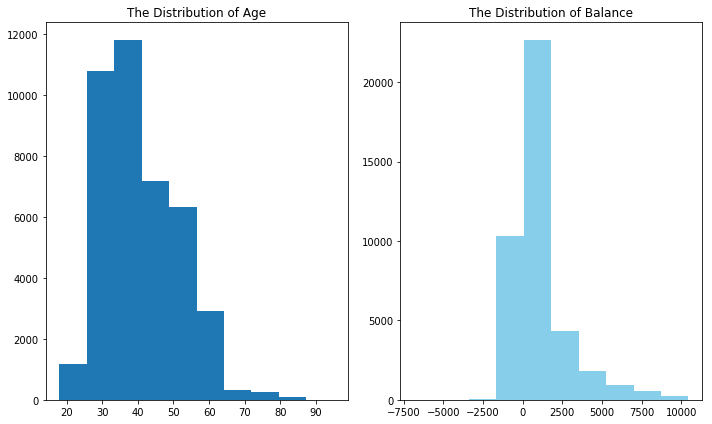

In [14]:
dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1) 
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(dataset7['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(dataset7['balance'], color = 'skyblue')
ra2.set_title('The Distribution of Balance')

plt.tight_layout() 
plt.show()

## Visualize the relationship between 'age' and 'balance'

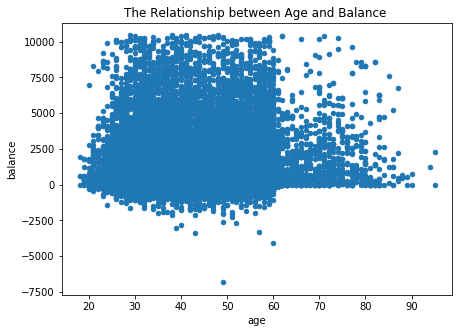

In [15]:
scatter_age_balance = dataset7.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

## Visualize the distribution of 'duration' & 'campaign'

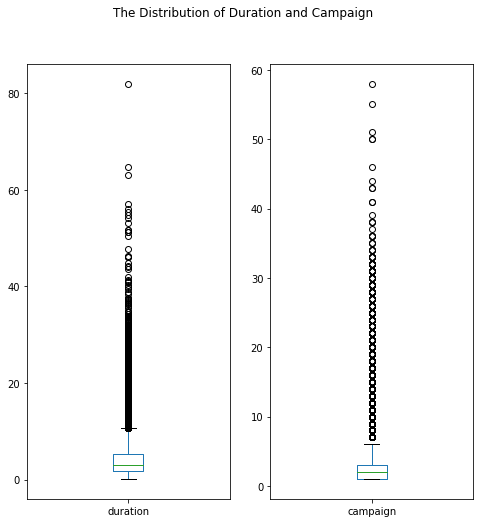

In [16]:
dist_dur_cam = dataset7[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

## Visualize the relationship between 'duration' & 'campaign': with response result

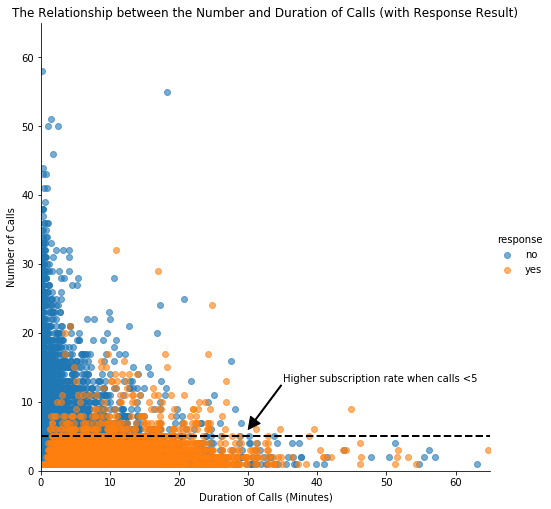

In [17]:
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = dataset7,
                     hue = 'response',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

## Scatter matrix and Correlation matrix

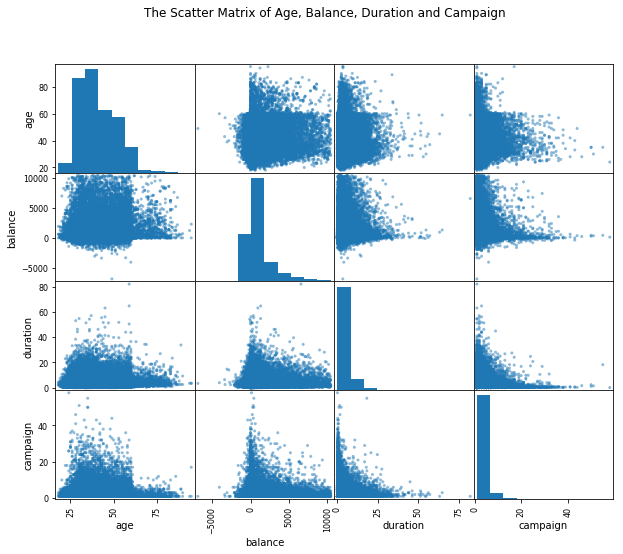

In [18]:
from pandas.plotting import scatter_matrix
matrix = scatter_matrix(dataset7[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

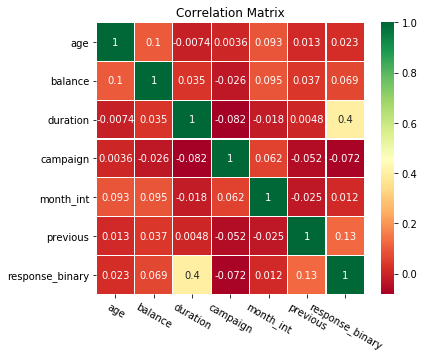

In [19]:
corr_data = dataset7[['age','balance','duration','campaign','month_int','previous','response_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

## Load the cleaned dataset

In [21]:
linkname = 'C:/Users/dell/Downloads/bank_cleaned.csv/bank_cleaned.csv'
dataset = read_csv(linkname)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [22]:
# View the first 5 rows of cleaned data
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0


## Prepare Data for Classification

## Select variables relevant to customers

In [23]:
dataset.drop(['marital'],axis=1, inplace=True)
dataset1 = dataset.iloc[:, 0:7]

## Tranform categorical data into dummy variables

In [24]:
dataset2 = pd.get_dummies(dataset1, columns = ['job'])
dataset2 = pd.get_dummies(dataset2, columns = ['education'])
dataset2['housing'] = dataset2['housing'].map({'yes': 1, 'no': 0})
dataset2['default'] = dataset2['default'].map({'yes': 1, 'no': 0})
dataset2['loan'] = dataset2['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset2 = pd.merge(dataset2, dataset_response, left_index = True, right_index = True)

## Feature selection

In [25]:
array = dataset2.values

# Features: first 20 columns
X = array[:,0:-1]

# Target variable: 'response_binary'
Y = array[:,-1]

## Train/ test split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [27]:
# 20% of the data will be used for testing
test_size= 0.20
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [29]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [30]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10, random_state=seed)    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.885284 (0.005933)
KNN: 0.874938 (0.004055)
CART: 0.833190 (0.006330)
NB: 0.823855 (0.005429)


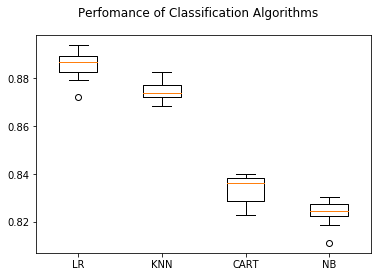

In [31]:
fig = plt.figure()
fig.suptitle('Perfomance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results_c)
ax.set_xticklabels(names_c)
plt.show()

# Test LR model on the test set

In [32]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
predictions = LR.predict(X_test)

In [34]:
# Accuracy Score 
print(accuracy_score(Y_test, predictions))

0.890806708287428


[[7277    1]
 [ 891    0]]


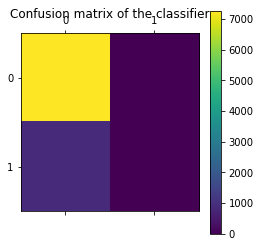

In [35]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import pylab as pl

print(confusion_matrix(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()


from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

# Machine Learning: Regression

In [37]:
dataset4 = dataset2.drop(['response_binary'],axis = 1)
dataset4['duration'] = dataset['duration']

# Feature selection

In [38]:
array = dataset4.values
X = array[:,0:20]
Y = array[:,20]

In [39]:
test_size= 0.20
seed = 10
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [41]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

In [42]:
results_e2 = []
names_e2 = []

for name, model in models:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state=seed)
    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2.append(cv_results)
    names_e2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -18.667426 (1.243464)
LASSO: -18.701201 (1.256921)
RIDGE: -18.667404 (1.243472)
EN: -18.700962 (1.256775)
KNN: -22.237990 (1.196449)
CART: -37.877293 (1.594328)


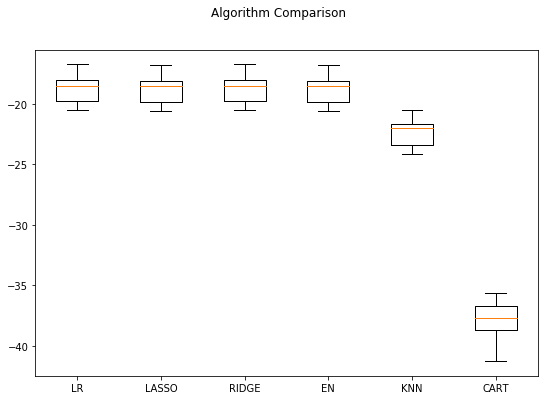

In [43]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

## Stardardize Data

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))

In [45]:
results_e2_normalized = []
names_e2_normalized = []

for name, model in pipelines:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state=seed)
    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2_normalized.append(cv_results)
    names_e2_normalized.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -18.667448 (1.244456)
ScaledLASSO: -18.721218 (1.268503)
ScaledRIDGE: -18.667425 (1.243465)
ScaledEN: -18.721218 (1.268503)
ScaledKNN: -22.097842 (1.358002)
ScaledCART: -37.626712 (1.792374)


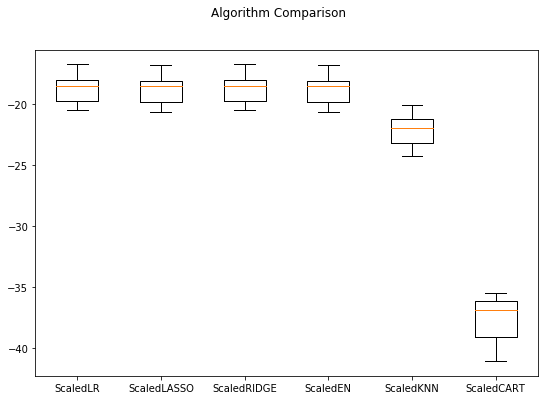

In [46]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2_normalized)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2_normalized)
plt.show()

In [47]:
ridge = Ridge()
ridge.fit(X_train, Y_train)
predicted_y = ridge.predict(X_test)

In [48]:
from sklearn.metrics import mean_squared_error
print('The MSE is', mean_squared_error(Y_test, predicted_y))

The MSE is 17.779740432944696


In [ ]:
According to the previous analysis, observations on duration are extremely varied from 0.1 to 81.97 minutes in this dataset. Therefore, a 17.78 MSE testifies that ridge regression is a sound model in predicting the target variable and suggest that the bank can roughly estimate the duration of campaign calls of each client using their customer profiles such as age, job, and loans.